# Introduction 2:
## Visualization in jupyter notebook


### Reading in the data:
- We use xarray here, but you can also use e.g. iris or even pyaerocom!
- We recomend however, that you use a package that keeps track of your coordinates in your data and the metadata in your data! (E.g. numpy doesn't do this) 
- This is also why the NetCDF format is so popular -- it keeps track of these things and is extremely easy to load with these packages. 


In [7]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
# or
# from imports import (plt, np, xr)
path='../../data_sample/wrf_out.small.h5' 
ds = xr.open_dataset(path)#, decode_times=False)

Check how your dataset looks

In [8]:
#lets check how the dataset looks like
ds

<xarray.Dataset>
Dimensions:  (XTIME: 1449, bottom_top: 10, south_north: 17, west_east: 23)
Coordinates:
    XLAT     (south_north, west_east) float32 ...
    XLONG    (south_north, west_east) float32 ...
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Dimensions without coordinates: bottom_top, south_north, west_east
Data variables:
    P        (XTIME, bottom_top, south_north, west_east) float32 ...
    V        (XTIME, bottom_top, south_north, west_east) float32 ...
    U        (XTIME, bottom_top, south_north, west_east) float32 ...
    T        (XTIME, bottom_top, south_north, west_east) float32 ...

**Check the attributes! Can be useful info here:**

In [9]:
ds['XTIME']

<xarray.DataArray 'XTIME' (XTIME: 1449)>
array(['2017-12-02T00:00:00.000000000', '2017-12-02T03:00:00.000000000',
       '2017-12-02T06:00:00.000000000', ..., '2018-05-31T18:00:00.000000000',
       '2018-05-31T21:00:00.000000000', '2018-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
Attributes:
    FieldType:    104
    MemoryOrder:  0  
    description:  minutes since 2017-12-02 00:00:00
    stagger:      

**Assign attributes!** Nice for plotting and to keep track of what is in your dataset (especially 'units' and 'standard_name'/'long_name' will be looked for by xarray.

In [10]:
# lets process potential temperature into C
ds['T_C'] = ds['T'] + 300 - 273
ds['T_C'] = ds['T_C'].assign_attrs({'units': 'C'})

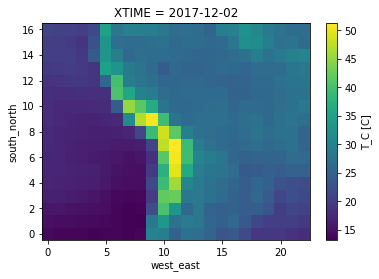

In [11]:
# lets do a basic plot of T_C
ds['T_C'].isel(XTIME=0,bottom_top=0).plot()
# analogy:
#ds[T_C][{ilev:0,time:0}].plot()

The coordinate 'south_north' annoyes me, so I change it!

In [12]:
# Initially just a number, I want the actual latitude!
ds['south_north'] = ds.XLAT[:,0]
ds['west_east']   = ds.XLONG[0,:]
# Rename them!
ds=ds.rename({'south_north':'lat',
              'west_east'  :'lon'    })

In [13]:
## from zarray import : 

Easier to type if we define some names:

In [14]:
#lets define some constants for the variable names so that calling them is easier.
ilev = 'bottom_top'
lat = 'lat'
lon = 'lon'
XT  = 'XTIME'
time = 'XTIME'
lat = 'XLAT'
lon = 'XLONG'
P, V, U, T = 'P','V','U','T'

#this is potential temperature in C
T_C = 'T_C'

## Plotting

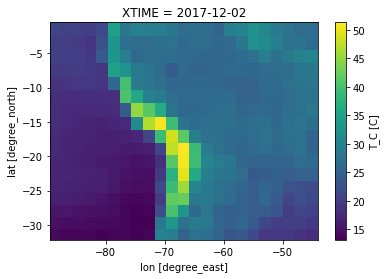

In [15]:
# lets do a basic plot of T_C
ds[T_C].isel(XTIME=0,bottom_top=0).plot()

# analogy:
#ds[T_C][{ilev:0,time:0}].plot()

### Make new variables:

In [16]:
WS = 'Wind speed'

ds[WS] = np.sqrt(ds[U]**2+ ds[V]**2)

ds[WS].attrs['units']='m/s'
ds[WS].attrs['name']='Wind speed'

## Use cartopy

In [17]:
import cartopy as cy

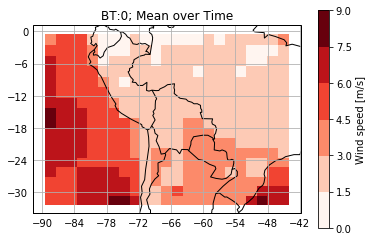

In [18]:
f,ax = plt.subplots(subplot_kw={'projection':cy.crs.PlateCarree()})
_ds = ds[{ilev:0}]
_dm = _ds[WS].mean(time, keep_attrs=True)
_dm.plot.pcolormesh(
    cmap     = plt.get_cmap('Reds'),
    ax       = ax,
    transform= cy.crs.PlateCarree(),
    levels   = 6
)

ax.set_title('BT:0; Mean over Time')
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.xlabels_top   = False
gl.ylabels_right = False
ax.add_feature(cy.feature.BORDERS);

### Quick statistics:

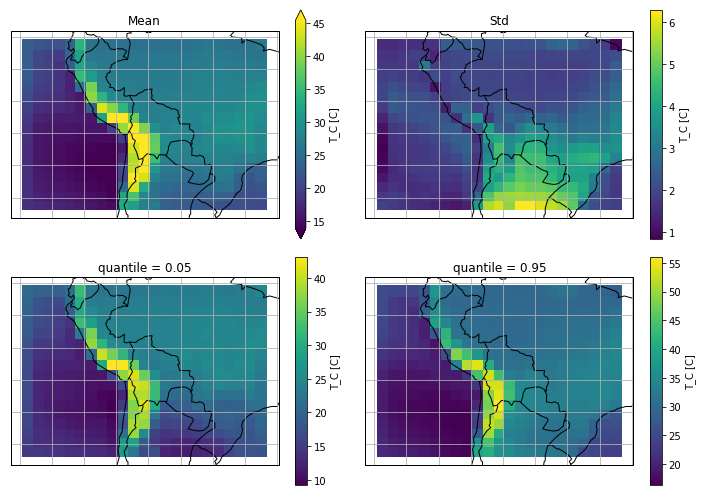

In [19]:
import cartopy.crs as ccrs
import cartopy as cy
fig, axsm = plt.subplots(2,2, 
                         figsize=[10,7], 
                         subplot_kw={'projection':ccrs.PlateCarree()})
axs = axsm.flatten()
_ds = ds[T_C][{ilev:0}]
_ds.mean(time, keep_attrs=True).plot(ax=axs[0], 
                                     transform=ccrs.PlateCarree(), 
                                     robust=True)
axs[0].set_title('Mean')
_ds.std(time, keep_attrs=True).plot(ax=axs[1], 
                                    transform=ccrs.PlateCarree())#, robust=True)
axs[1].set_title('Std')
_ds.quantile(0.05, dim=time, keep_attrs=True).plot(ax=axs[2], 
                                                   transform=ccrs.PlateCarree())#, robust=True)
_ds.quantile(0.95, dim=time, keep_attrs=True).plot(ax=axs[3], 
                                                   transform=ccrs.PlateCarree())#, robust=True)
for ax in axs:
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl.xlabels_top = False
    gl.ylabels_right = False

plt.tight_layout()

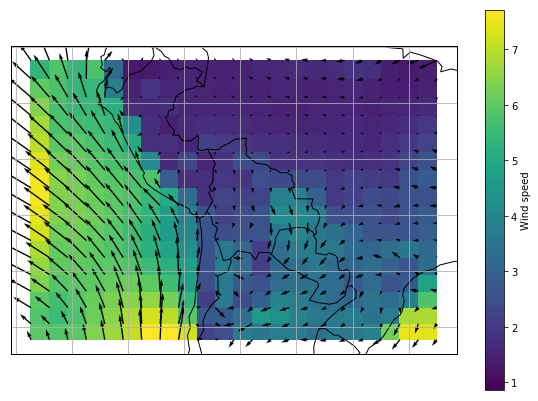

In [20]:
import cartopy.crs as ccrs
import cartopy as cy
fig, ax = plt.subplots(1, 
                       figsize=[10,7], 
                       subplot_kw={'projection':ccrs.PlateCarree()})

_ds = ds[[U,V, WS]][{ilev:0}].mean(XT) #keep_attrs=True)
_ds[WS].plot(x=lon, y=lat, transform=ccrs.PlateCarree())
ax.quiver(_ds[lon], 
          _ds[lat], 
          _ds['U'],
          _ds['V'], 
          transform=ccrs.PlateCarree())
ax.coastlines()
gl = ax.gridlines()
ax.add_feature(cy.feature.BORDERS);
#plt.tight_layout()

### Tired of making plots:

In [21]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)

def add_map_features(ax):
    ax.coastlines()
    gl = ax.gridlines()
    ax.add_feature(cy.feature.BORDERS);
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False




/home/sarambl/anaconda3/envs/general/lib/python3.6/site-packages/xarray/core/common.py:608: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, the dimension order of these coordinates will be restored as well unless you specify restore_coord_dims=False.
  self, group, squeeze=squeeze, restore_coord_dims=restore_coord_dims


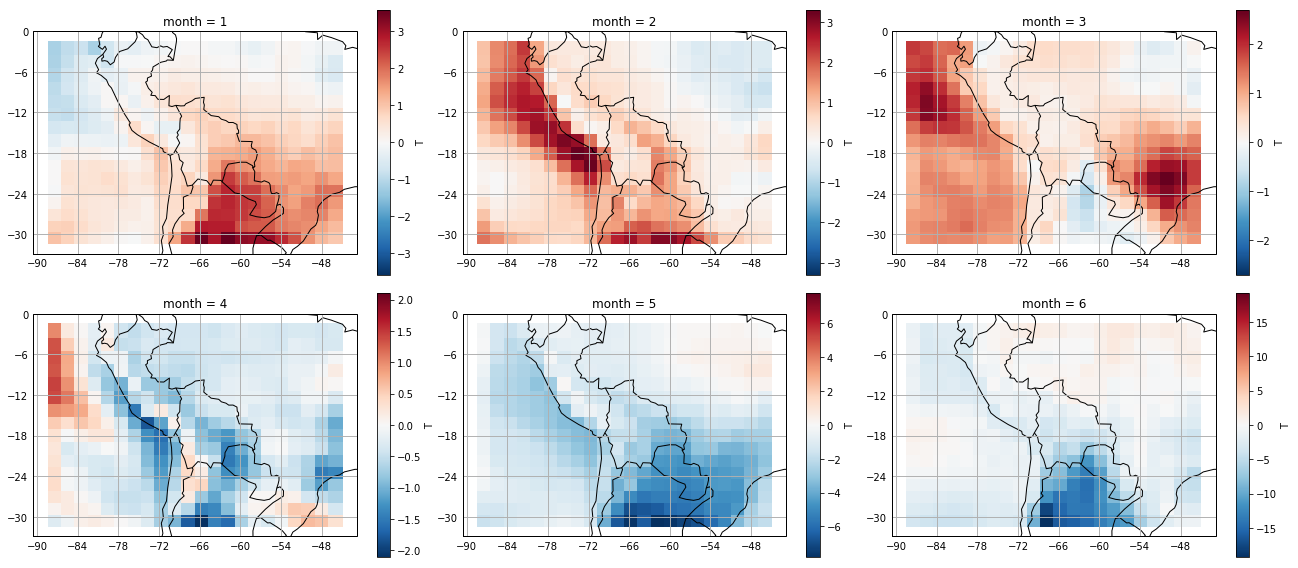

In [22]:
fig, axs = sp_map(2,3, figsize=[18,8], sharex=True, sharey=True)

# Use groupby! (doesn't need to be in time):
T_mm = ds[T][{ilev:0}].groupby('XTIME.month').mean(XT)
T_mean = ds[T][{ilev:0}].mean(XT)
# let's check the deviation from the mean over the whole period! (Easier to see)

# MARK: THIS WOULD NOT WORK IN NUMPY!
T_dev = T_mm- T_mean
for mo, ax in zip(T_mm['month'], axs.flatten()):
    T_dev.sel(month=mo).plot(x=lon, y=lat, ax=ax, transform=ccrs.PlateCarree())
    add_map_features(ax)
plt.tight_layout()

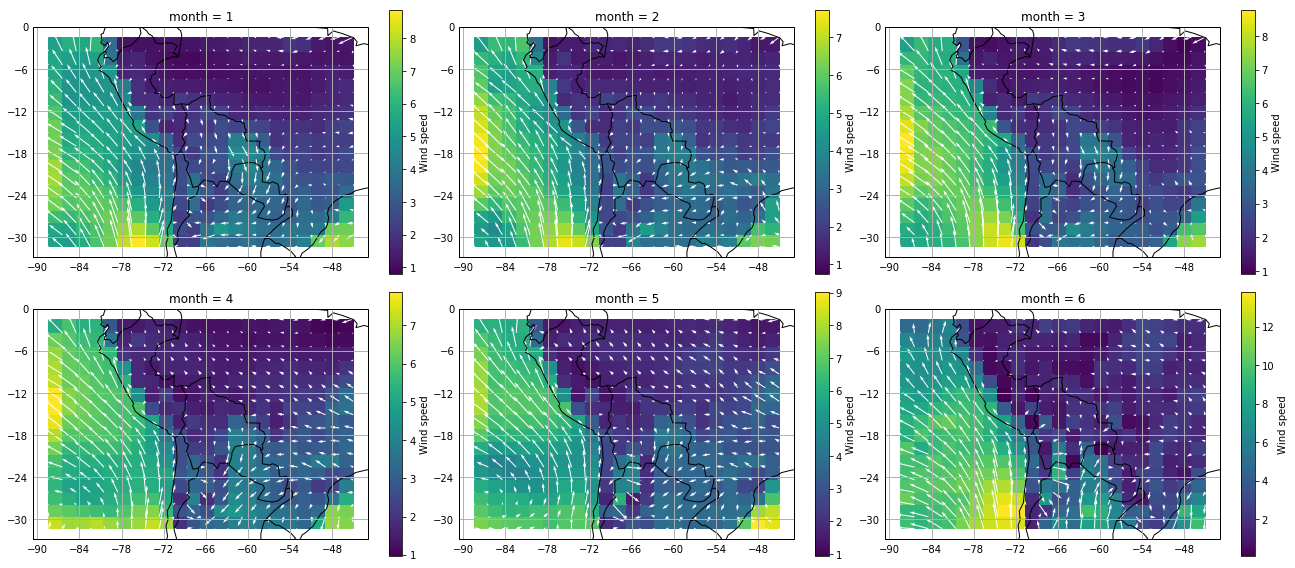

In [23]:
fig, axs = sp_map(2,3, figsize=[18,8])
# select bottom layer and group by month and apply mean:
W_mm = ds[{ilev:0}].groupby('XTIME.month').mean(XT)

for mo, ax in zip(T_mm['month'], axs.flatten()):
    _dsm = W_mm.sel(month=mo)
    _dsm[WS].plot(x=lon, y=lat, ax=ax, transform=ccrs.PlateCarree())
    ax.quiver(_dsm[lon], _dsm[lat], 
              _dsm['U'], _dsm['V'], 
              transform=ccrs.PlateCarree(), color='w')

    add_map_features(ax)
plt.tight_layout()

## Lev lat plot:

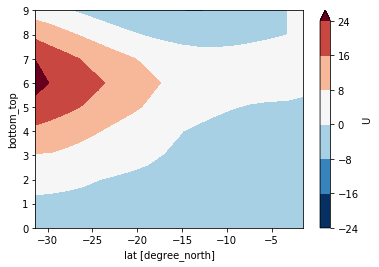

In [24]:
ds[U].mean([time, 'lon']).plot.contourf(robust=True)

## Typical pandas methods often apply (or have an analogy): Daily max, daily min.
Google xarray and the name of your favorite function

In [25]:
ds_dmax = ds.resample(XTIME='1D').max()
ds_dmin = ds.resample(XTIME='1D').min()


In [26]:
ds_dmax

<xarray.Dataset>
Dimensions:     (XTIME: 182, bottom_top: 10, lat: 17, lon: 23)
Coordinates:
  * XTIME       (XTIME) datetime64[ns] 2017-12-02 2017-12-03 ... 2018-06-01
    XLAT        (lat, lon) float32 -31.348223 -31.348223 ... -1.4679687
    XLONG       (lat, lon) float32 -88.401634 -86.42826 ... -46.96108 -44.987724
  * lat         (lat) float32 -31.348223 -29.648048 ... -3.439331 -1.4679687
  * lon         (lon) float32 -88.401634 -86.42826 ... -46.96108 -44.987724
Dimensions without coordinates: bottom_top
Data variables:
    P           (XTIME, bottom_top, lat, lon) float32 2622.2117 ... 0.08257812
    V           (XTIME, bottom_top, lat, lon) float32 7.277119 ... 0.3874269
    U           (XTIME, bottom_top, lat, lon) float32 -3.5968585 ... 0.5220239
    T           (XTIME, bottom_top, lat, lon) float32 -12.887212 ... 133.33698
    T_C         (XTIME, bottom_top, lat, lon) float32 14.112793 ... 160.33698
    Wind speed  (XTIME, bottom_top, lat, lon) float32 8.117503 ... 0.65008

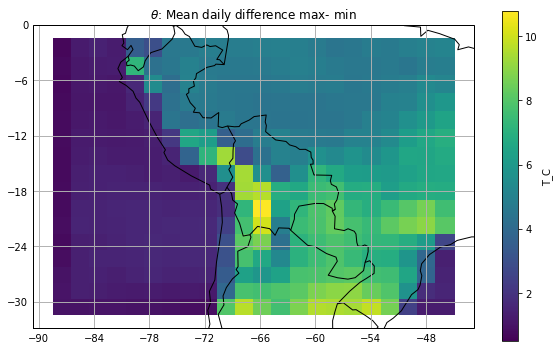

In [27]:
fig, ax = sp_map(1, figsize = [8,5])
ds_diffmm = ds_dmax -ds_dmin
_diff = ds_diffmm[{ilev:0}].mean(time)
kwargs = { 'transform':ccrs.PlateCarree()}
_diff[T_C].plot(x=lon, y=lat, ax=ax, **kwargs)
ax.set_title(r'$\theta$: Mean daily difference max- min')
add_map_features(ax)
plt.tight_layout()

## Check a particular place (e.g. to compare to observations)
Chacaltaya measuring station is located at roughly (-16.34, -68.12). We will pick out the grid cell closest to this. 

In [28]:
CHC =      {'lat' : -16.34, 'lon' : -68.12}
#marine =   {'lat' : -16.44, 'lon' : -72.24}
#amazonas = {'lat' : -5.08,  'lon' : -64.44}

In [29]:
ds

<xarray.Dataset>
Dimensions:     (XTIME: 1449, bottom_top: 10, lat: 17, lon: 23)
Coordinates:
    XLAT        (lat, lon) float32 ...
    XLONG       (lat, lon) float32 ...
  * XTIME       (XTIME) datetime64[ns] 2017-12-02 ... 2018-06-01
  * lat         (lat) float32 -31.348223 -29.648048 ... -3.439331 -1.4679687
  * lon         (lon) float32 -88.401634 -86.42826 ... -46.96108 -44.987724
Dimensions without coordinates: bottom_top
Data variables:
    P           (XTIME, bottom_top, lat, lon) float32 ...
    V           (XTIME, bottom_top, lat, lon) float32 6.276596 ... 0.3874269
    U           (XTIME, bottom_top, lat, lon) float32 -4.7214103 ... 0.5220239
    T           (XTIME, bottom_top, lat, lon) float32 -12.887212 ... 133.33698
    T_C         (XTIME, bottom_top, lat, lon) float32 14.112793 ... 160.33698
    Wind speed  (XTIME, bottom_top, lat, lon) float32 7.8541307 ... 0.65008354

In [30]:
_ds = ds[{ilev:0}]
ds_chc = _ds.sel(lat=CHC['lat'], 
                 lon=CHC['lon'],
                 method='nearest')

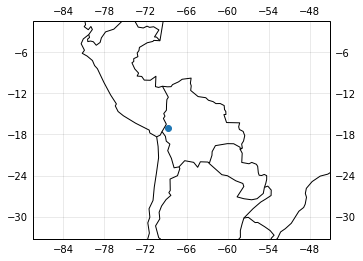

In [31]:
ax = plt.axes(projection=cy.crs.PlateCarree())
ax.set_extent([ds[lon].min(),
               ds[lon].max(),
               ds[lat].min(),
               ds[lat].max()
              ])
ax.scatter(ds_chc[lon],ds_chc[lat])
ax.coastlines()
ax.add_feature(cy.feature.BORDERS);
gl = ax.gridlines(draw_labels=True,color='k',alpha=.1)

In [32]:
_df = ds_chc.to_dataframe()

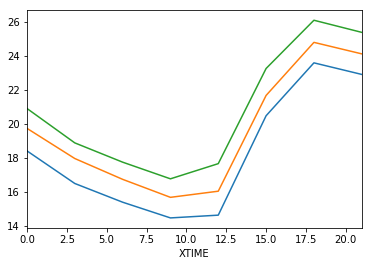

In [33]:
f, ax = plt.subplots()
_group = _df['T'].groupby(_df.index.hour)
qs = [.25,.5,.75]
for q in qs:
    _group.quantile(q).plot(ax=ax, label=q)

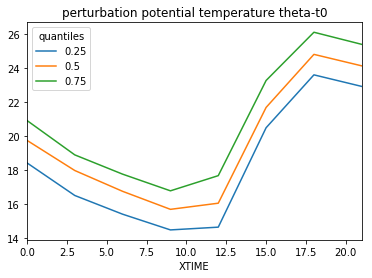

In [34]:
ax.set_title(ds['T'].description)
ax.legend(title='quantiles')
ax.figure

#### More plotting with pandas:
- https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html


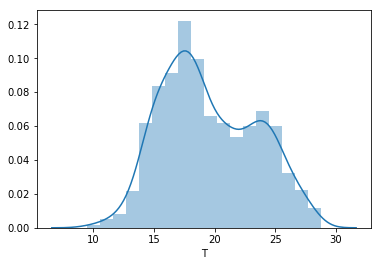

In [35]:
import seaborn as sns
sns.distplot(_df['T'])